<a href="https://colab.research.google.com/github/yevonnaelandrew/galaxy-classification-ensemble/blob/main/All_Color_Space_DenseNet201_Non_trainable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu May 12 10:17:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
2.7789665710006375
GPU (s):
0.03508042599969485
GPU speedup over CPU: 79x


In [2]:
from google.colab import drive
import os
import glob
import pandas as pd

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!cp /content/drive/MyDrive/galaxy-images/img_RGB.zip /content/img_RGB.zip

In [6]:
!unzip /content/img_RGB.zip

Streaming output truncated to the last 5000 lines.
  inflating: content/img_RGB/spiral/598869.jpg  
  inflating: content/img_RGB/spiral/111799.jpg  
  inflating: content/img_RGB/spiral/780317.jpg  
  inflating: content/img_RGB/spiral/910544.jpg  
  inflating: content/img_RGB/spiral/834411.jpg  
  inflating: content/img_RGB/spiral/733208.jpg  
  inflating: content/img_RGB/spiral/886610.jpg  
  inflating: content/img_RGB/spiral/911110.jpg  
  inflating: content/img_RGB/spiral/708993.jpg  
  inflating: content/img_RGB/spiral/412282.jpg  
  inflating: content/img_RGB/spiral/329964.jpg  
  inflating: content/img_RGB/spiral/550580.jpg  
  inflating: content/img_RGB/spiral/481037.jpg  
  inflating: content/img_RGB/spiral/981685.jpg  
  inflating: content/img_RGB/spiral/213331.jpg  
  inflating: content/img_RGB/spiral/545684.jpg  
  inflating: content/img_RGB/spiral/979242.jpg  
  inflating: content/img_RGB/spiral/791017.jpg  
  inflating: content/img_RGB/spiral/797954.jpg  
  inflating: conte

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
!pip install tensorflow-io
import tensorflow_io as tfio

In [6]:
def train_model(convert_color, original=False, preprocess=False):

  data_dir = pathlib.Path('/content/content/img_RGB')

  batch_size = 64
  img_height = 128
  img_width = 128

  IMG_SHAPE = (img_height, img_width) + (3,)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  AUTOTUNE = tf.data.AUTOTUNE
  num_classes = len(class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

  # Create the base model from the pre-trained model
  base_model = tf.keras.applications.DenseNet201(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  
  base_model.trainable = False

  inputs = tf.keras.Input(shape=(128, 128, 3))
  x = data_augmentation(inputs)

  if original == True:
    print("Using the original RGB and preprocessing")
    x = tf.keras.applications.densenet.preprocess_input(x)
  elif original == False:
    x = tf.keras.layers.Rescaling(scale=1./255)(x)
    x = convert_color(x)
    print("Using the converted colors")

  if preprocess == True:
    x = tf.keras.applications.densenet.preprocess_input(x)
    print("Using preprocessing")

  x = base_model(x)
  x = tf.keras.layers.MaxPooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  outputs = tf.keras.layers.Dense(5)(x)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0005

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  epochs=50
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the original RGB and preprocessing
Epoch 1/50
360/360 [==============================] - 60s 103ms/step - loss: 0.6076 - accuracy: 0.7395 - val_loss: 0.5179 - val_accuracy: 0.7780
Epoch 2/50
360/360 [==============================] - 32s 88ms/step - loss: 0.4983 - accuracy: 0.7874 - val_loss: 0.4469 - val_accuracy: 0.8143
Epoch 3/50
360/360 [==============================] - 32s 88ms/step - loss: 0.4713 - accuracy: 0.7974 - val_loss: 0.4262 - val_accuracy: 0.8164
Epoch 4/50
360/360 [==============================] - 32s 89ms/step - loss: 0.4636 - accuracy: 0.8034 - val_loss: 0.4115 - val_accuracy: 0.8314
Epoch 5/50
360/360 [==============================] - 32s 88ms/step - loss: 0.4397 - accuracy: 0.8129 - val_loss: 0.4294 - val_accuracy: 0.8164
Epoch 6/50
360/360 [==============================] - 32s 88ms/step - loss: 0.4374 - accu

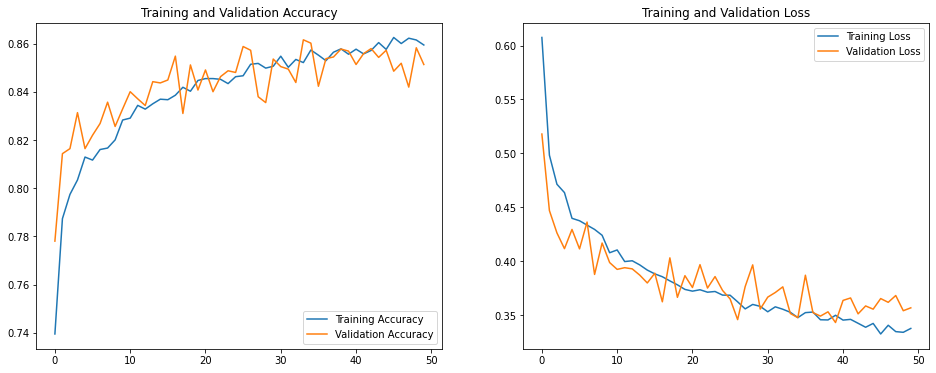

In [7]:
train_model(None, original=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/50
360/360 [==============================] - 69s 112ms/step - loss: 0.7006 - accuracy: 0.7048 - val_loss: 0.5820 - val_accuracy: 0.7675
Epoch 2/50
360/360 [==============================] - 33s 91ms/step - loss: 0.5908 - accuracy: 0.7453 - val_loss: 0.5276 - val_accuracy: 0.7775
Epoch 3/50
360/360 [==============================] - 33s 91ms/step - loss: 0.5538 - accuracy: 0.7664 - val_loss: 0.5074 - val_accuracy: 0.7853
Epoch 4/50
360/360 [==============================] - 33s 91ms/step - loss: 0.5467 - accuracy: 0.7665 - val_loss: 0.5616 - val_accuracy: 0.7527
Epoch 5/50
360/360 [==============================] - 33s 91ms/step - loss: 0.5378 - accuracy: 0.7679 - val_loss: 0.4881 - val_accuracy: 0.7956
Epoch 6/50
360/360 [==============================] - 33s 92ms/step - loss: 0.5233 

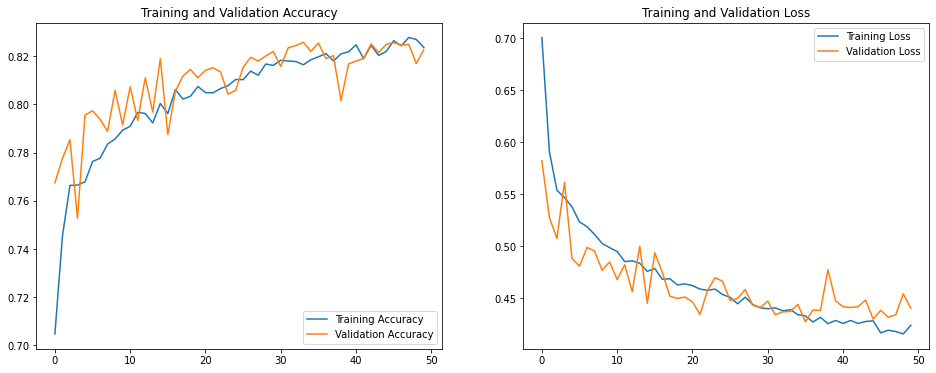

In [8]:
train_model(tfio.experimental.color.rgb_to_lab, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/50
360/360 [==============================] - 57s 101ms/step - loss: 0.9887 - accuracy: 0.6254 - val_loss: 0.7431 - val_accuracy: 0.6844
Epoch 2/50
360/360 [==============================] - 33s 91ms/step - loss: 0.7123 - accuracy: 0.6964 - val_loss: 0.6823 - val_accuracy: 0.7079
Epoch 3/50
360/360 [==============================] - 33s 91ms/step - loss: 0.6792 - accuracy: 0.7144 - val_loss: 0.6319 - val_accuracy: 0.7253
Epoch 4/50
360/360 [==============================] - 33s 91ms/step - loss: 0.6543 - accuracy: 0.7253 - val_loss: 0.5997 - val_accuracy: 0.7504
Epoch 5/50
360/360 [==============================] - 33s 91ms/step - loss: 0.6341 - accuracy: 0.7375 - val_loss: 0.5971 - val_accuracy: 0.7536
Epoch 6/50
360/360 [==============================] - 33s 91ms/step - loss: 0.6162 - accuracy: 0.7419 -

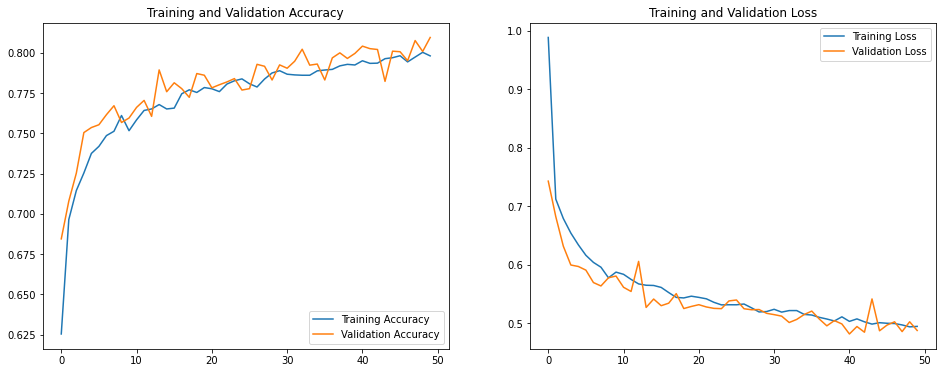

In [9]:
train_model(tfio.experimental.color.rgb_to_lab, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/50
360/360 [==============================] - 57s 100ms/step - loss: 1.4409 - accuracy: 0.2913 - val_loss: 1.4223 - val_accuracy: 0.2890
Epoch 2/50
360/360 [==============================] - 32s 90ms/step - loss: 1.4266 - accuracy: 0.2957 - val_loss: 1.4084 - val_accuracy: 0.2860
Epoch 3/50
360/360 [==============================] - 32s 90ms/step - loss: 1.4208 - accuracy: 0.3048 - val_loss: 1.3968 - val_accuracy: 0.4217
Epoch 4/50
360/360 [==============================] - 32s 90ms/step - loss: 1.4169 - accuracy: 0.3075 - val_loss: 1.4036 - val_accuracy: 0.2978
Epoch 5/50
360/360 [==============================] - 32s 90ms/step - loss: 1.4034 - accuracy: 0.3318 - val_loss: 1.3891 - val_accuracy: 0.2973
Epoch 6/50
360/360 [==============================] - 32s 90ms/step - loss: 1.3832 

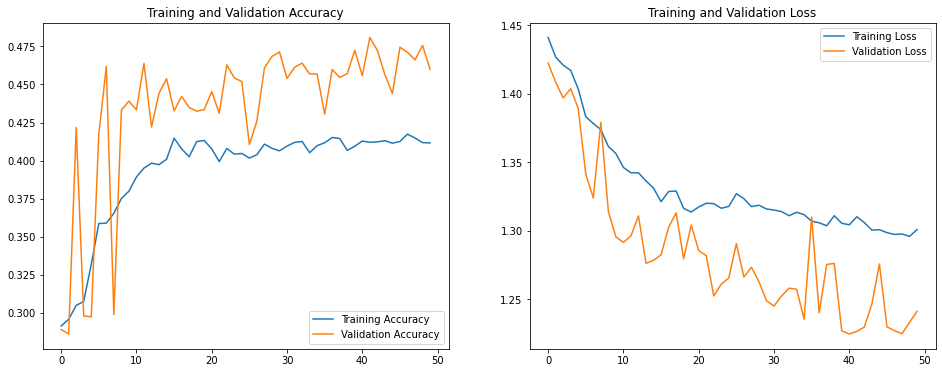

In [10]:
train_model(tfio.experimental.color.rgb_to_xyz, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/50
360/360 [==============================] - 57s 102ms/step - loss: 0.5608 - accuracy: 0.7639 - val_loss: 0.4342 - val_accuracy: 0.8234
Epoch 2/50
360/360 [==============================] - 33s 91ms/step - loss: 0.4385 - accuracy: 0.8210 - val_loss: 0.3536 - val_accuracy: 0.8663
Epoch 3/50
360/360 [==============================] - 33s 91ms/step - loss: 0.4061 - accuracy: 0.8346 - val_loss: 0.3555 - val_accuracy: 0.8557
Epoch 4/50
360/360 [==============================] - 33s 91ms/step - loss: 0.3792 - accuracy: 0.8474 - val_loss: 0.3220 - val_accuracy: 0.8809
Epoch 5/50
360/360 [==============================] - 33s 91ms/step - loss: 0.3769 - accuracy: 0.8482 - val_loss: 0.3442 - val_accuracy: 0.8633
Epoch 6/50
360/360 [==============================] - 33s 91ms/step - loss: 0.3627 - accuracy: 0.8534 -

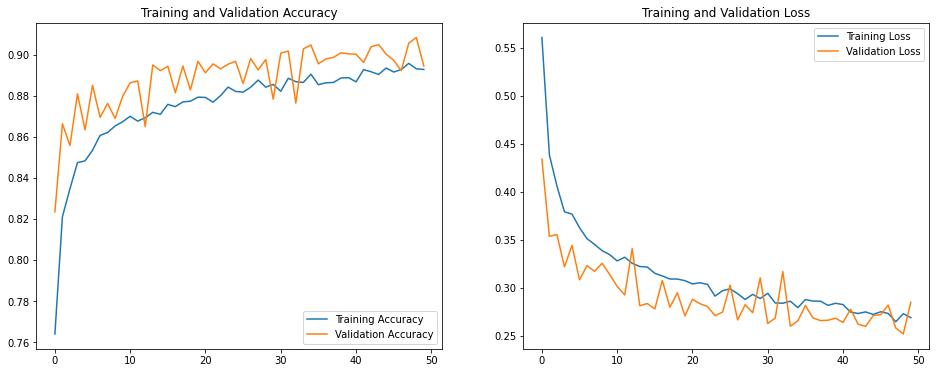

In [11]:
train_model(tfio.experimental.color.rgb_to_xyz, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/50
360/360 [==============================] - 58s 100ms/step - loss: 1.2248 - accuracy: 0.4461 - val_loss: 1.0619 - val_accuracy: 0.5472
Epoch 2/50
360/360 [==============================] - 33s 90ms/step - loss: 1.0742 - accuracy: 0.5204 - val_loss: 1.0106 - val_accuracy: 0.5570
Epoch 3/50
360/360 [==============================] - 32s 90ms/step - loss: 1.0432 - accuracy: 0.5357 - val_loss: 0.9650 - val_accuracy: 0.5639
Epoch 4/50
360/360 [==============================] - 32s 89ms/step - loss: 1.0252 - accuracy: 0.5480 - val_loss: 0.9469 - val_accuracy: 0.5702
Epoch 5/50
360/360 [==============================] - 32s 89ms/step - loss: 1.0020 - accuracy: 0.5583 - val_loss: 0.9249 - val_accuracy: 0.5976
Epoch 6/50
360/360 [==============================] - 32s 90ms/step - loss: 0.9944 

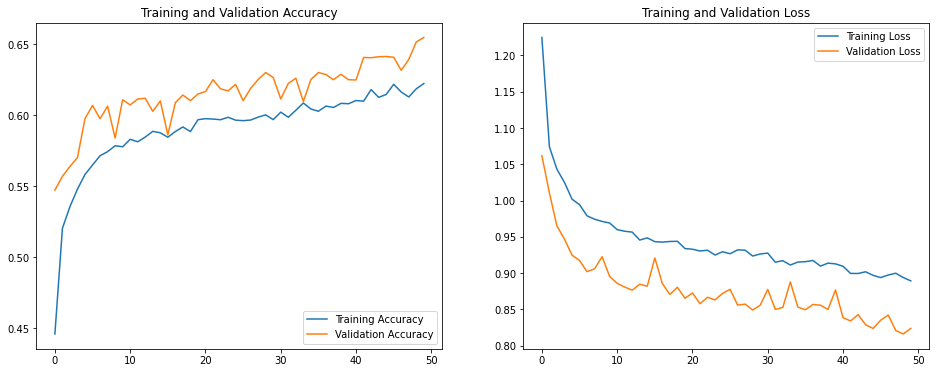

In [12]:
train_model(tfio.experimental.color.rgb_to_hsv, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/50
360/360 [==============================] - 58s 102ms/step - loss: 0.9057 - accuracy: 0.6186 - val_loss: 0.7676 - val_accuracy: 0.6492
Epoch 2/50
360/360 [==============================] - 32s 90ms/step - loss: 0.7762 - accuracy: 0.6667 - val_loss: 0.7142 - val_accuracy: 0.6898
Epoch 3/50
360/360 [==============================] - 32s 90ms/step - loss: 0.7432 - accuracy: 0.6791 - val_loss: 0.7001 - val_accuracy: 0.6891
Epoch 4/50
360/360 [==============================] - 33s 90ms/step - loss: 0.7219 - accuracy: 0.6832 - val_loss: 0.7072 - val_accuracy: 0.6869
Epoch 5/50
360/360 [==============================] - 33s 90ms/step - loss: 0.7220 - accuracy: 0.6850 - val_loss: 0.6999 - val_accuracy: 0.6938
Epoch 6/50
360/360 [==============================] - 33s 91ms/step - loss: 0.7032 - accuracy: 0.6974 -

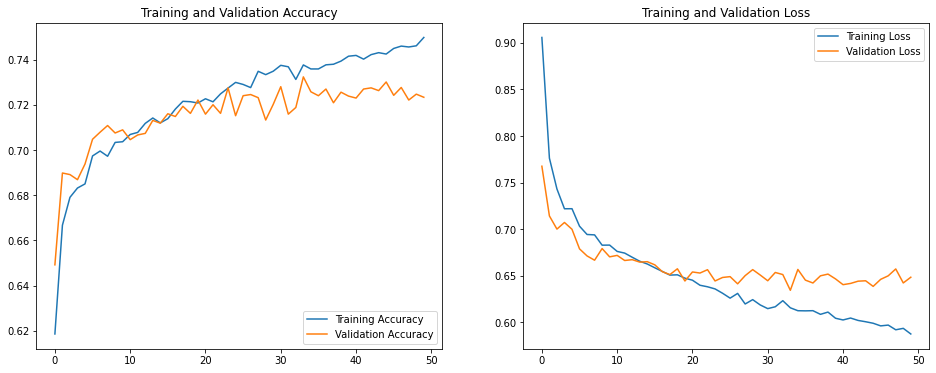

In [13]:
train_model(tfio.experimental.color.rgb_to_hsv, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/50
360/360 [==============================] - 58s 101ms/step - loss: 1.4440 - accuracy: 0.2828 - val_loss: 1.4117 - val_accuracy: 0.2860
Epoch 2/50
360/360 [==============================] - 33s 91ms/step - loss: 1.4254 - accuracy: 0.2875 - val_loss: 1.4159 - val_accuracy: 0.2860
Epoch 3/50
360/360 [==============================] - 33s 92ms/step - loss: 1.4200 - accuracy: 0.2900 - val_loss: 1.3963 - val_accuracy: 0.2860
Epoch 4/50
360/360 [==============================] - 33s 91ms/step - loss: 1.4074 - accuracy: 0.2984 - val_loss: 1.3684 - val_accuracy: 0.2881
Epoch 5/50
360/360 [==============================] - 33s 91ms/step - loss: 1.3794 - accuracy: 0.3158 - val_loss: 1.3800 - val_accuracy: 0.3413
Epoch 6/50
360/360 [==============================] - 33s 91ms/step - loss: 1.3616 

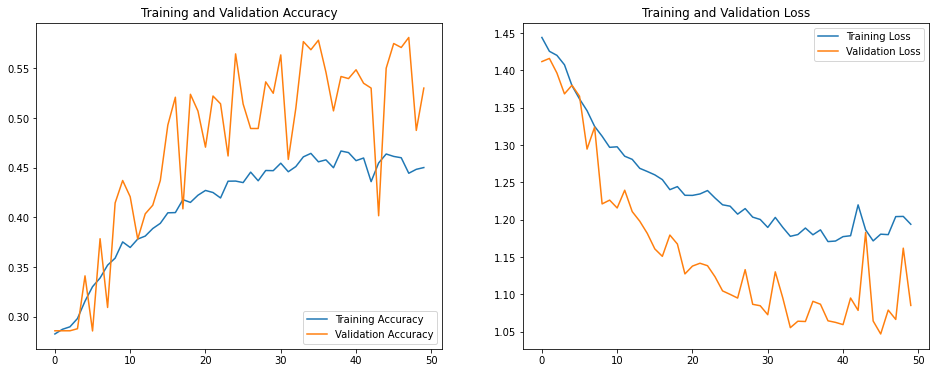

In [14]:
train_model(tfio.experimental.color.rgb_to_yuv, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/50
360/360 [==============================] - 58s 103ms/step - loss: 0.6026 - accuracy: 0.7507 - val_loss: 0.4134 - val_accuracy: 0.8267
Epoch 2/50
360/360 [==============================] - 33s 92ms/step - loss: 0.4759 - accuracy: 0.7994 - val_loss: 0.5024 - val_accuracy: 0.7869
Epoch 3/50
360/360 [==============================] - 33s 92ms/step - loss: 0.4499 - accuracy: 0.8138 - val_loss: 0.4028 - val_accuracy: 0.8355
Epoch 4/50
360/360 [==============================] - 33s 92ms/step - loss: 0.4345 - accuracy: 0.8198 - val_loss: 0.3753 - val_accuracy: 0.8493
Epoch 5/50
360/360 [==============================] - 33s 92ms/step - loss: 0.4264 - accuracy: 0.8239 - val_loss: 0.3763 - val_accuracy: 0.8503
Epoch 6/50
360/360 [==============================] - 33s 92ms/step - loss: 0.4147 - accuracy: 0.8318 -

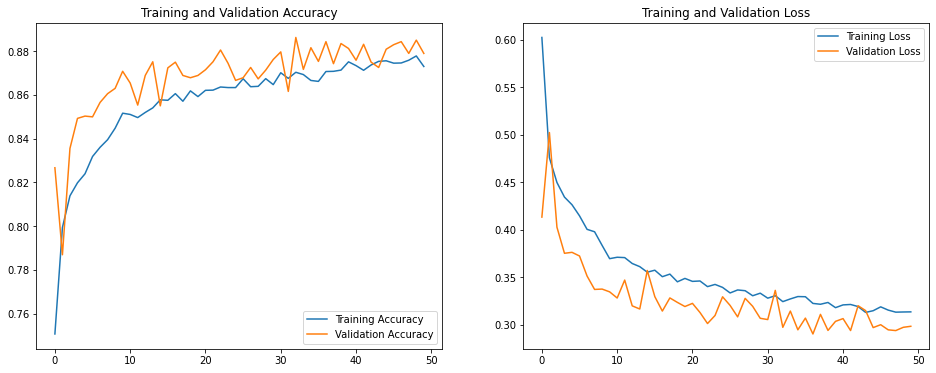

In [15]:
train_model(tfio.experimental.color.rgb_to_yuv, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/50
360/360 [==============================] - 58s 102ms/step - loss: 1.4388 - accuracy: 0.2903 - val_loss: 1.4068 - val_accuracy: 0.2746
Epoch 2/50
360/360 [==============================] - 33s 93ms/step - loss: 1.4151 - accuracy: 0.3138 - val_loss: 1.3801 - val_accuracy: 0.3805
Epoch 3/50
360/360 [==============================] - 33s 92ms/step - loss: 1.3831 - accuracy: 0.3447 - val_loss: 1.3412 - val_accuracy: 0.4592
Epoch 4/50
360/360 [==============================] - 33s 92ms/step - loss: 1.3249 - accuracy: 0.3884 - val_loss: 1.2484 - val_accuracy: 0.4144
Epoch 5/50
360/360 [==============================] - 33s 92ms/step - loss: 1.2725 - accuracy: 0.4251 - val_loss: 1.1688 - val_accuracy: 0.4858
Epoch 6/50
360/360 [==============================] - 33s 92ms/step - loss: 1.2372 

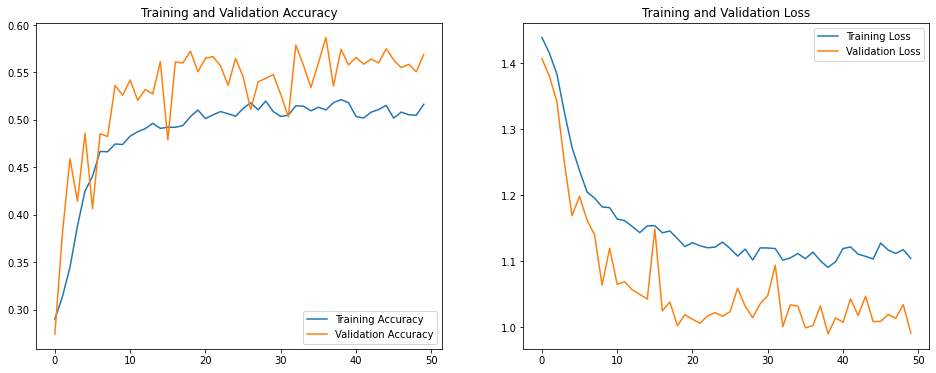

In [16]:
train_model(tfio.experimental.color.rgb_to_ydbdr, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/50
360/360 [==============================] - 58s 102ms/step - loss: 0.7289 - accuracy: 0.6848 - val_loss: 0.6174 - val_accuracy: 0.7315
Epoch 2/50
360/360 [==============================] - 33s 92ms/step - loss: 0.6342 - accuracy: 0.7239 - val_loss: 0.5577 - val_accuracy: 0.7492
Epoch 3/50
360/360 [==============================] - 37s 104ms/step - loss: 0.5992 - accuracy: 0.7407 - val_loss: 0.5553 - val_accuracy: 0.7520
Epoch 4/50
360/360 [==============================] - 33s 92ms/step - loss: 0.5859 - accuracy: 0.7436 - val_loss: 0.5462 - val_accuracy: 0.7603
Epoch 5/50
360/360 [==============================] - 33s 92ms/step - loss: 0.5755 - accuracy: 0.7486 - val_loss: 0.5605 - val_accuracy: 0.7501
Epoch 6/50
360/360 [==============================] - 33s 92ms/step - loss: 0.5630 - accuracy: 0.7566 

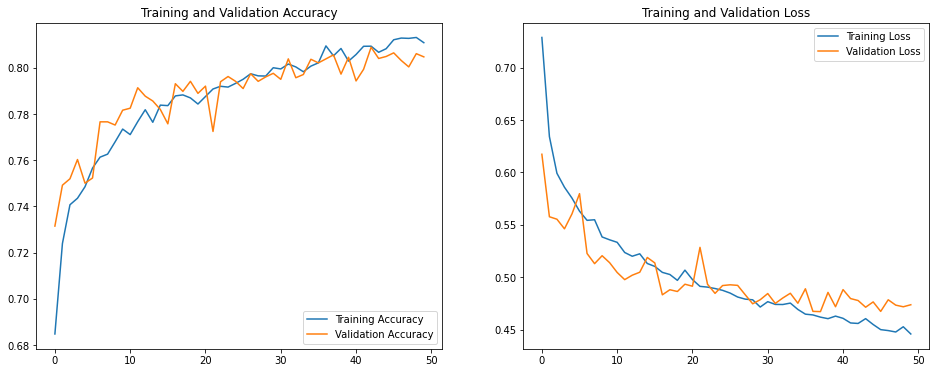

In [17]:
train_model(tfio.experimental.color.rgb_to_ydbdr, preprocess=False)